# Fraud Transaction Prediction

**Note** - Read all the markdowns in between to understand the work flow and the findings

### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
import warnings
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

### Loading the dataset

In [2]:
data = pd.read_csv('Fraud.csv')
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
df = data.copy()

I created a copy of the original dataset to prevent changes to the original data.

### Exploring and Cleaning the data

#### Dataset info

In [4]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


#### Renaming column

In [5]:
# Rename the column 'oldbalanceOrg' to 'oldbalanceOrig'
df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'}, inplace=True)

#### Checking for null values

In [6]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


No null values were found

#### Checking the distribution of data based on 'Fraud transactions'

In [7]:
isFraud_count = df['isFraud'].value_counts()

# Display the count
print("(isFraud=1):", isFraud_count[1])
print("(isFraud=0):", isFraud_count[0])


isFlaggedFraud_count = df['isFlaggedFraud'].value_counts()

# Display the count
print("(isFlaggedFraud=1):", isFlaggedFraud_count[1])
print("(isFlaggedFraud=0):", isFlaggedFraud_count[0])

(isFraud=1): 8213
(isFraud=0): 6354407
(isFlaggedFraud=1): 16
(isFlaggedFraud=0): 6362604


Since the number of fraud transactions in the data is much less than the number of non-fraud transactions, the data is imbalanced. This imbalance can lead to a biased model, so we need to remove unnecessary data and try to balance it as much as possible.

#### Max and min amount of 'Overall Transactions' and 'Fraud Transaction'

In [8]:
print("Minimum Amount of Transaction", df['amount'].min())
print("Maximum Amount of Transaction", df['amount'].max())

fraud_transactions = df[df['isFraud'] == 1]

min_fraud_amount = fraud_transactions['amount'].min()
max_fraud_amount = fraud_transactions['amount'].max()

print("Minimum Amount of Fraud Transaction:", min_fraud_amount)
print("Maximum Amount of Fraud Transaction:", max_fraud_amount)
      

Minimum Amount of Transaction 0.0
Maximum Amount of Transaction 92445516.64
Minimum Amount of Fraud Transaction: 0.0
Maximum Amount of Fraud Transaction: 10000000.0


#### Distribution of All Transactions by 'type'

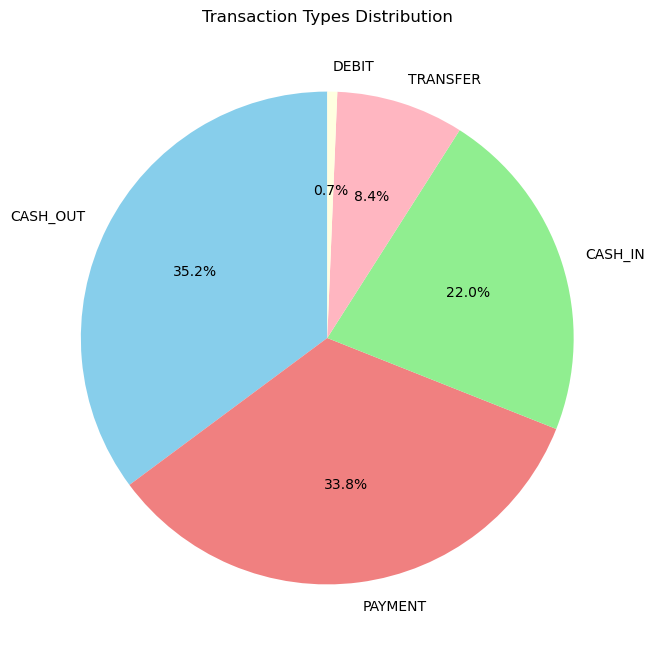

In [9]:
type_counts = df['type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightyellow'])
plt.title('Transaction Types Distribution')
plt.show()

#### Distribution of Fraud Transactions by 'type'

C:\Users\singh\AppData\Local\Temp\ipykernel_17740\3907908618.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='type', data=fraud_transactions, palette='viridis')


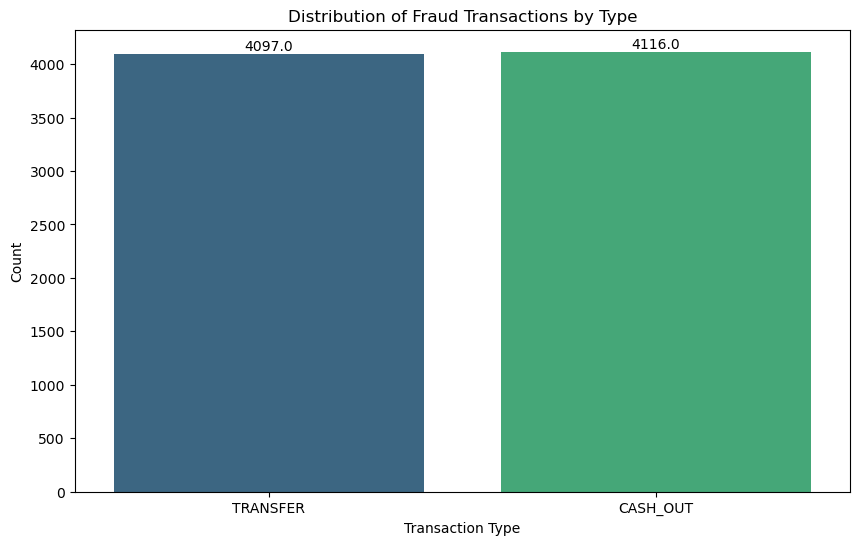

In [10]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='type', data=fraud_transactions, palette='viridis')

# Add count labels on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.title('Distribution of Fraud Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

Since fraud transactions are only of two types, either 'TRANSFER' or 'CASH_OUT', and we need to reduce the data to balance it as much as possible, we remove all other transaction records with a transaction type other than 'TRANSFER' or 'CASH_OUT'.

Also, since the transactions where 'nameDest' starts with 'M' have no information about the change in the balance of the destination, we will check the distribution of the data after removing the rows with 'nameDest' starting with 'M

#### Checking the 'type' of Merchant Transactions i.e. where the 'nameDest' starts with 'M' 

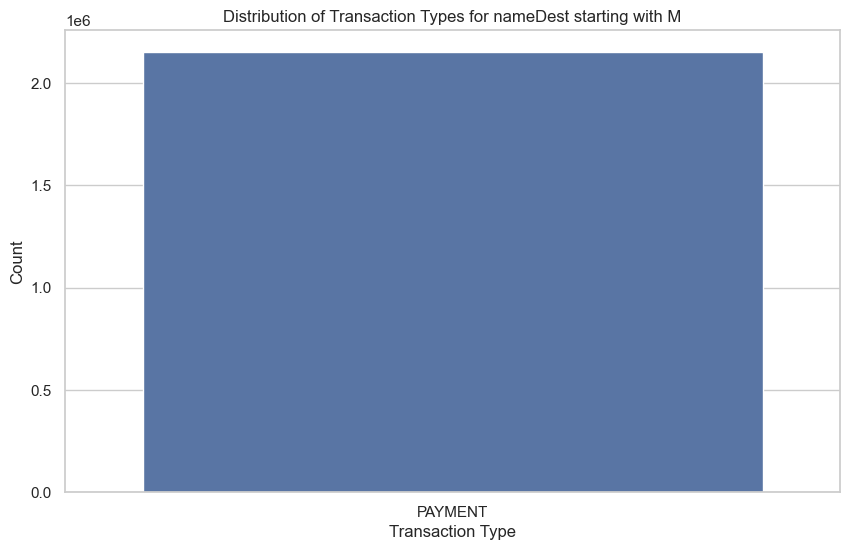

In [11]:
# Filter the data for transactions where nameDest starts with 'M'
merchant_transactions = df[df['nameDest'].str.startswith('M')]

# Set the style for the plots
sns.set(style="whitegrid")

# Create a countplot for the transaction types with 'nameDest' starting with 'M'
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=merchant_transactions)
plt.title('Distribution of Transaction Types for nameDest starting with M')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

All the transactions whose nameDest starts with 'M' have the transaction type PAYMENT, and anyhow, it was going to be removed, so there is no need to remove it separately.

#### Removing rows having transaction type other than 'TRANSFER' or 'CASH_OUT'

In [12]:
# Filter the dataframe to include only 'TRANSFER' and 'CASH_OUT' transaction types
filtered_df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

# Display the shape of the original and filtered dataframes
print("Original DataFrame Shape:", df.shape)
print("Filtered DataFrame Shape:", filtered_df.shape)

# Update the original dataframe with the filtered data
df = filtered_df.copy()

Original DataFrame Shape: (6362620, 11)
Filtered DataFrame Shape: (2770409, 11)


#### Distribution of fraud transactions by Amount

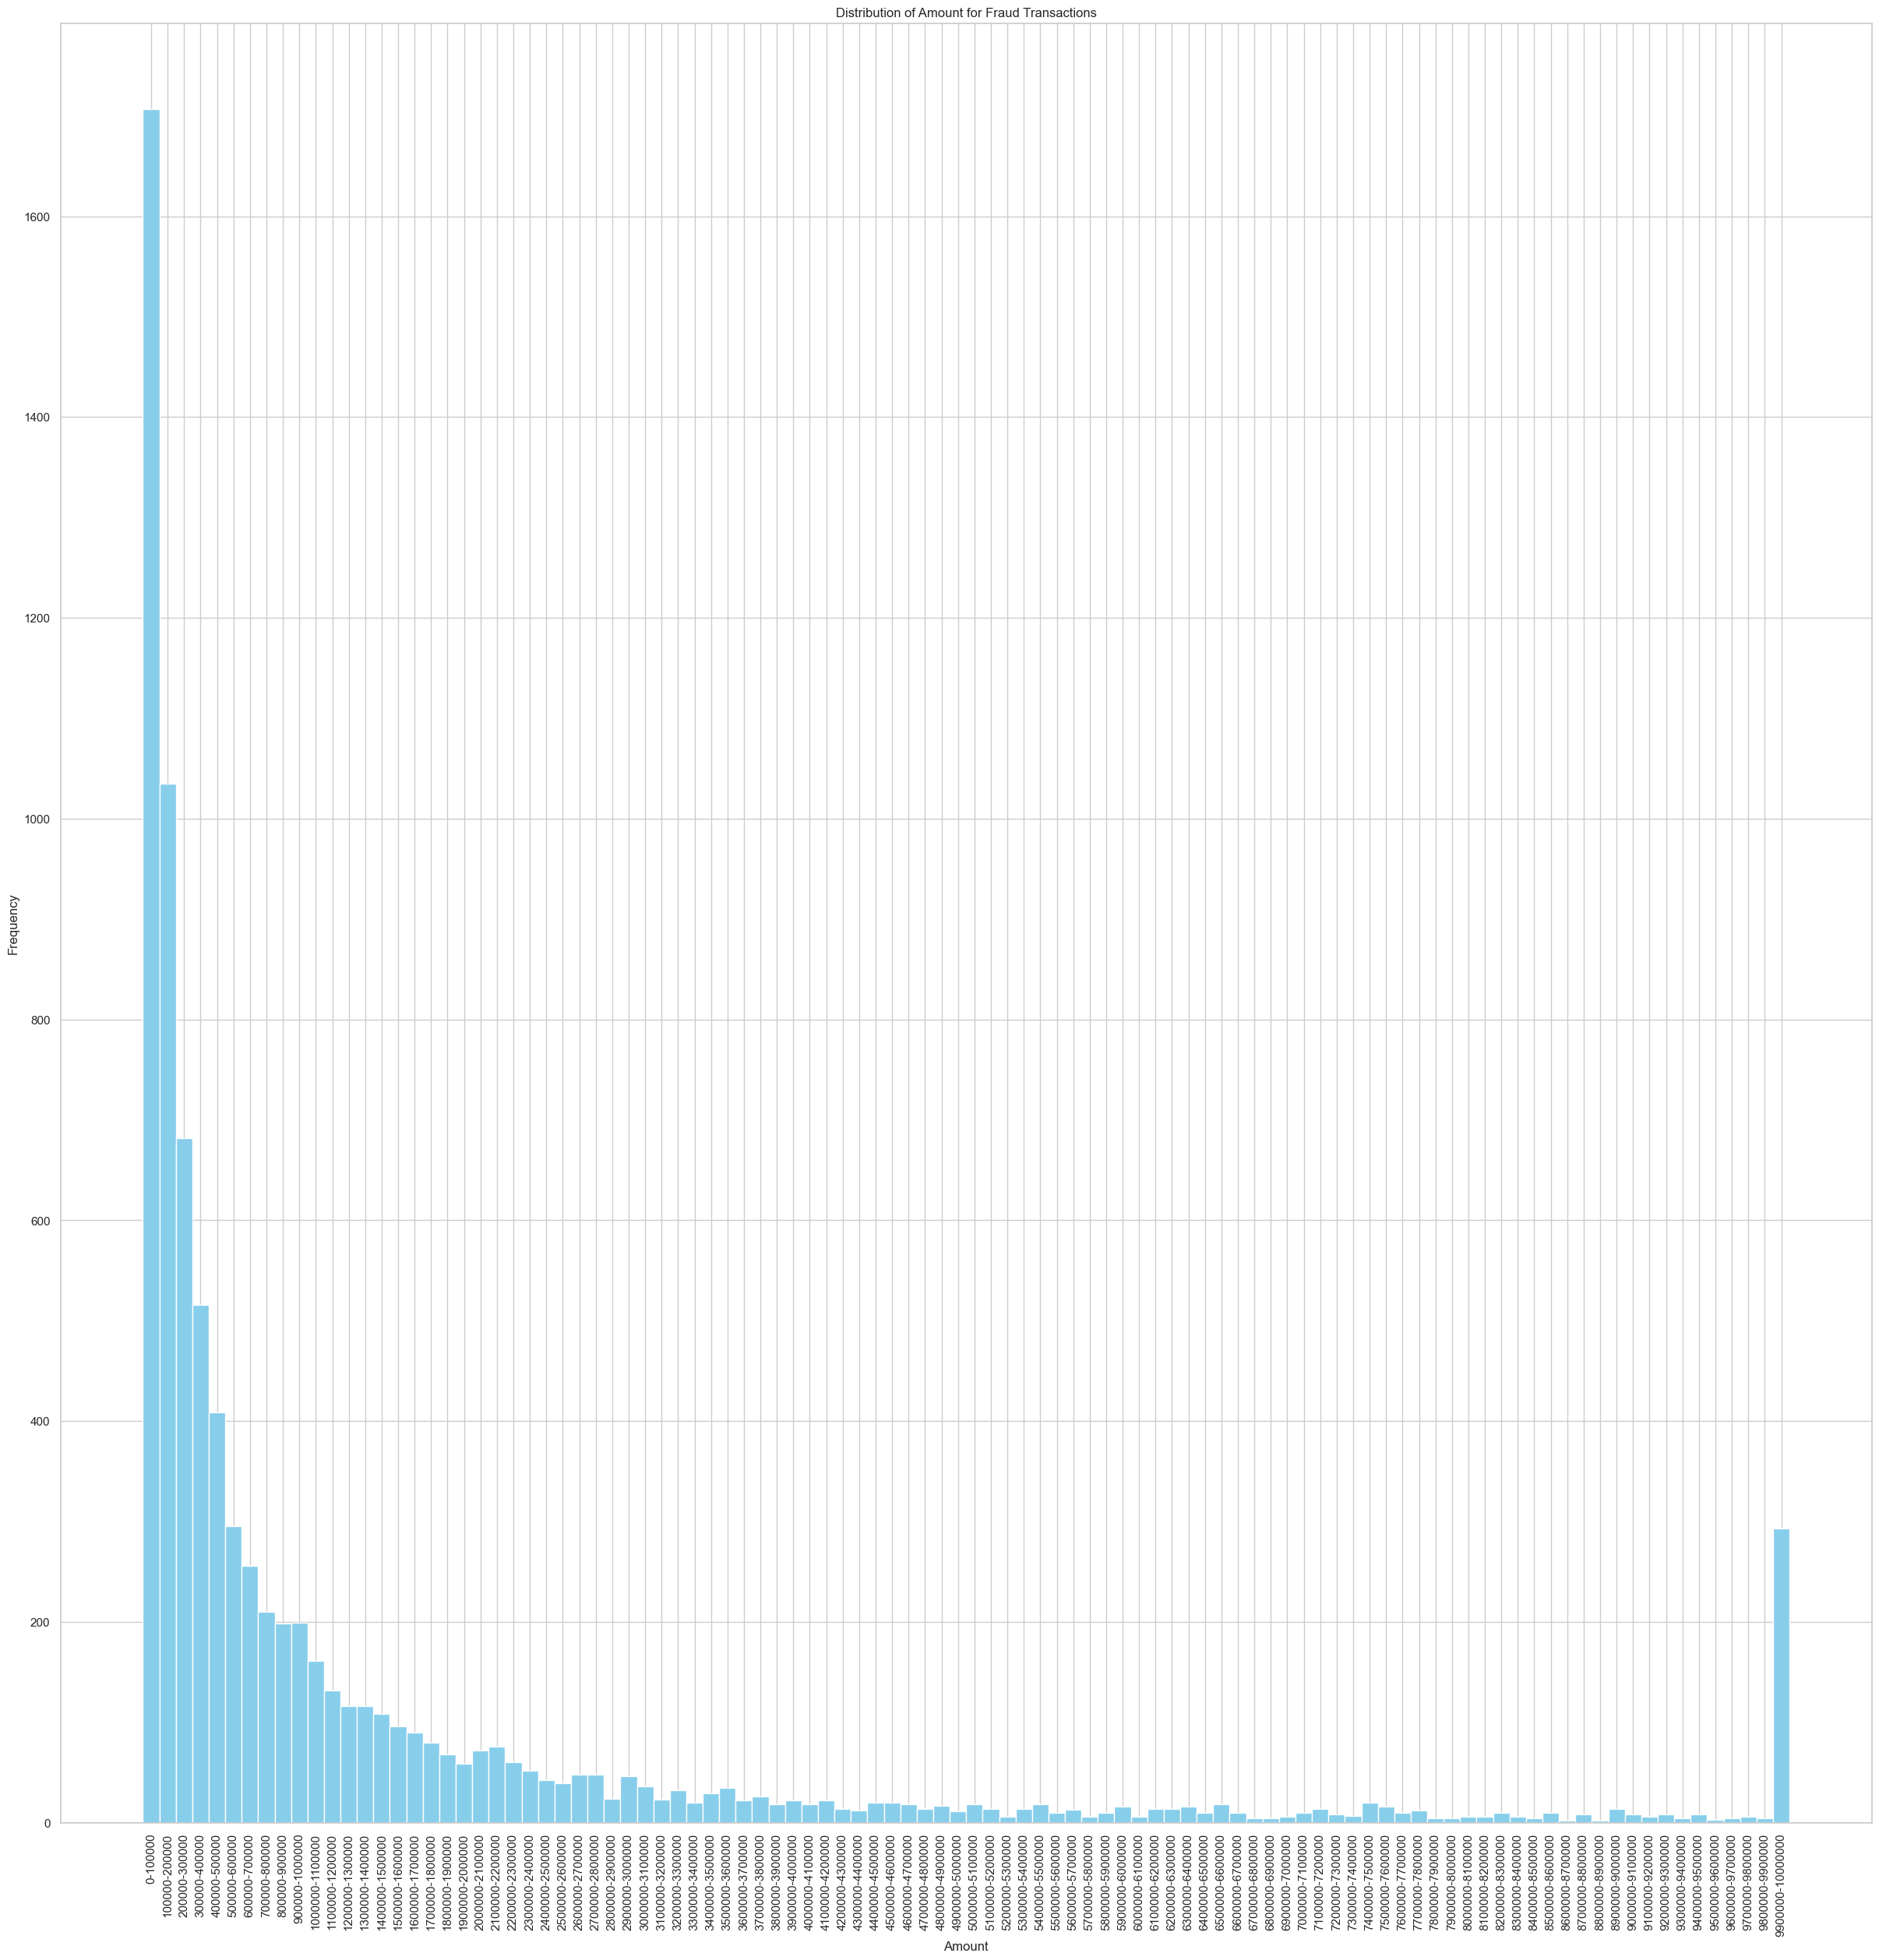

In [13]:
plt.figure(figsize=(30,30))
bins=range(0, int(fraud_transactions['amount'].max()+100000), 100000)
plt.hist(fraud_transactions['amount'], bins=bins, color='skyblue')
plt.title('Distribution of Amount for Fraud Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
bin_ranges = [f'{start}-{end}' for start, end in zip(bins[:-1], bins[1:])]
plt.xticks([(start + end) / 2 for start, end in zip(bins[:-1], bins[1:])], bin_ranges, rotation=90)
plt.show()

#Double tap to view properly

In [14]:
fraud_and_flagged = df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)].shape
print(fraud_and_flagged[0])

16


All the rows where 'isFlaggedFraud' equals 1 also have 'isFraud' equal to 1. Since 'isFlaggedFraud' is based on the bank rules for transactions with amounts exceeding 200,000, and fraud transactions have amounts varying from 0 to 10,000,000, also not all transactions with amounts greater than 200,000 are fraudulent. Therefore, this column does not hold significant importance in decision-making, so we drop the 'isFlaggedFraud' column.

In [15]:
df.drop('isFlaggedFraud', axis=1, inplace=True)

#### Rechecking the distribution of data based on 'Fraud Transactions'

In [16]:
isFraud_count = df['isFraud'].value_counts()

# Display the count
print("(isFraud=1):", isFraud_count[1])
print("(isFraud=0):", isFraud_count[0])

(isFraud=1): 8213
(isFraud=0): 2762196


#### Checking and removing outliers

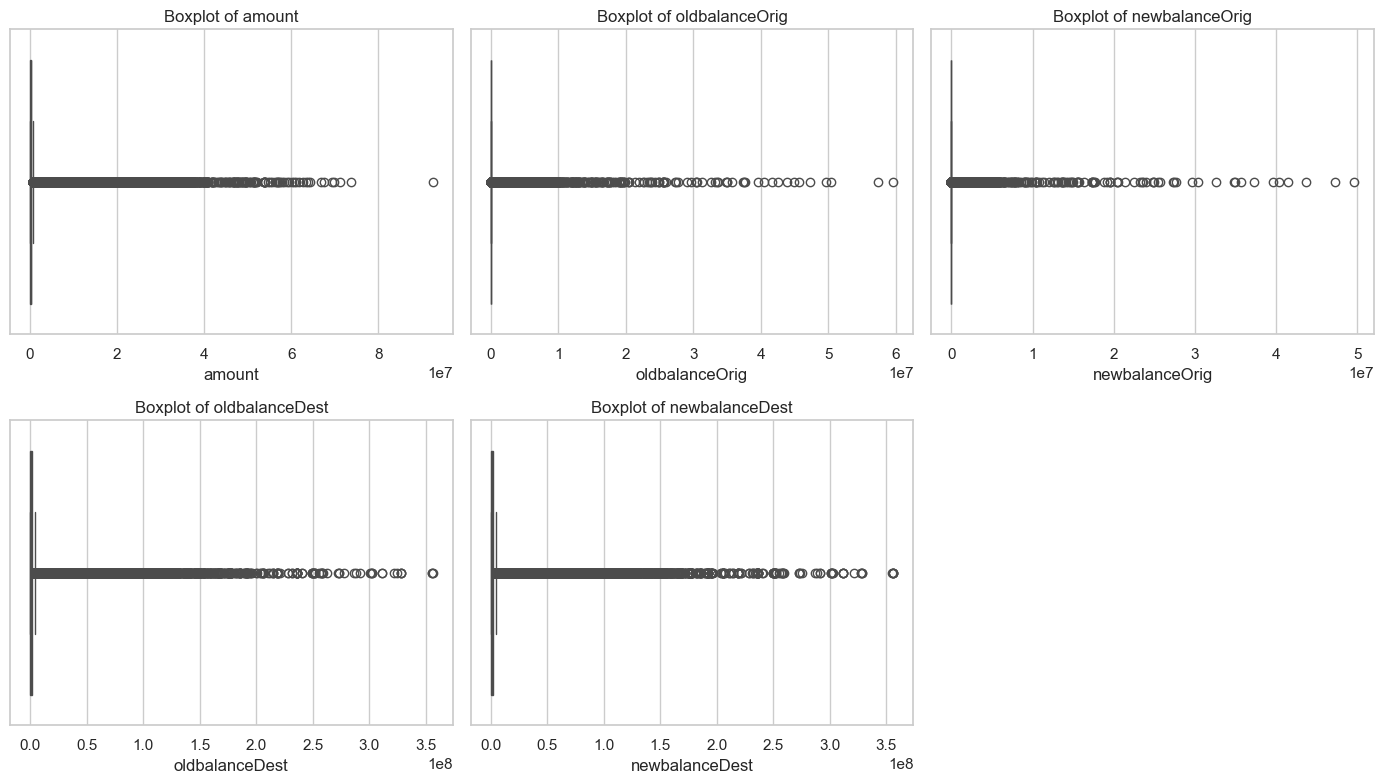

In [17]:
# Define the columns to create boxplots for
columns_to_boxplot = ['amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Set the style for the plots
sns.set(style="whitegrid")

# Create boxplots for each specified column
plt.figure(figsize=(14, 8))
for i, column in enumerate(columns_to_boxplot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

1) We go with 'amount'

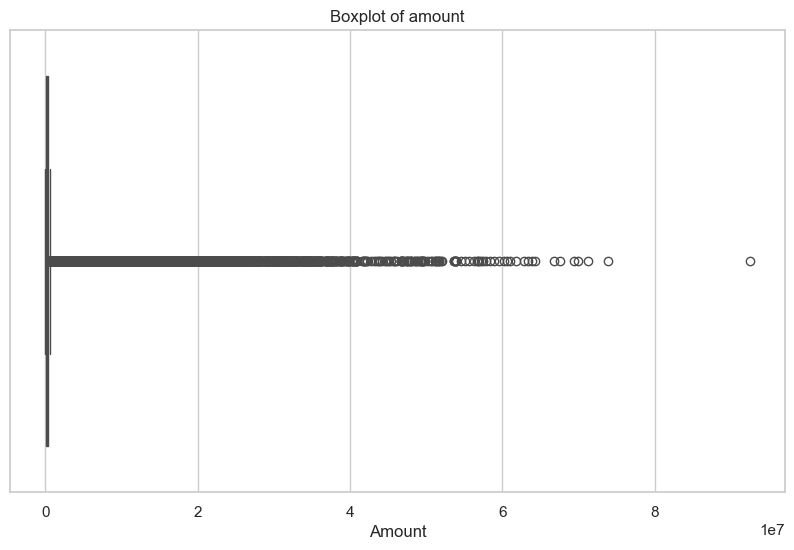

In [18]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='amount', data=df)
plt.title('Boxplot of amount')
plt.xlabel('Amount')
plt.show()

As we can observe, there is one transaction with an amount significantly higher than the others, indicating that it is an outlier.

In [19]:
# Identify outliers
outliers = df[df['amount'] > 80000000]

# Display the outliers
print("Outliers in Amount:")
print(outliers[['amount', 'nameOrig', 'nameDest']])

Outliers in Amount:
              amount     nameOrig    nameDest
3686583  92445516.64  C1715283297  C439737079


In [20]:
# Remove outliers from the DataFrame
df = df[df['amount'] <= 80000000]

# Display the shape of the DataFrame after removing outliers
print("DataFrame Shape after Removing Outliers:", df.shape)

DataFrame Shape after Removing Outliers: (2770408, 10)


2) Moving to 'oldbalanceOrig'

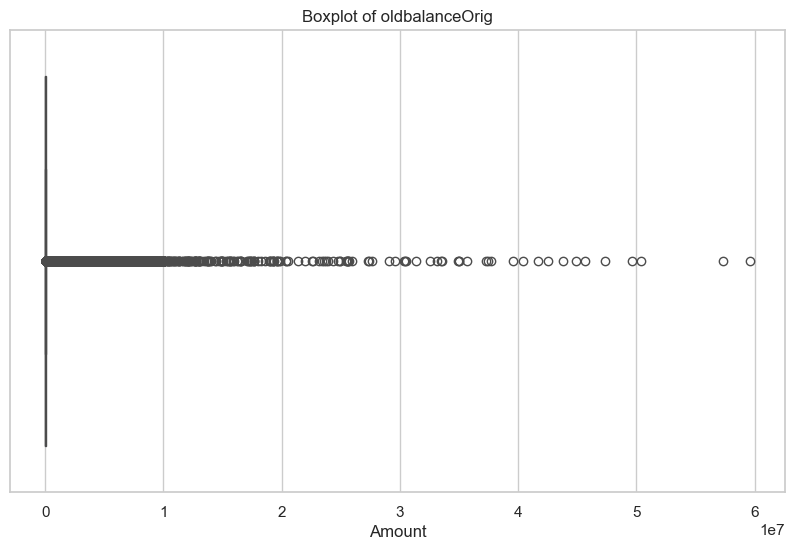

In [21]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='oldbalanceOrig', data=df)
plt.title('Boxplot of oldbalanceOrig')
plt.xlabel('Amount')
plt.show()

Here, the rows with 'oldbalanceOrig' more than 5,500,000 are considered as outliers.

In [22]:
# Identify outliers 
outliers = df[df['oldbalanceOrig'] > 55000000]

# Display the outliers
print("Outliers in oldbalanceOrig:")
print(outliers[['amount', 'nameOrig', 'nameDest']])

Outliers in oldbalanceOrig:
             amount    nameOrig     nameDest
5996399  10000000.0   C40489106   C650095152
6362452  10000000.0  C726730575  C1364745638


In [23]:
# Remove outliers from the DataFrame
df = df[df['oldbalanceOrig'] < 55000000]

# Display the shape of the DataFrame after removing outliers
print("DataFrame Shape after Removing Outliers:", df.shape)

DataFrame Shape after Removing Outliers: (2770406, 10)


3) Now going with 'newbalanceOrig'

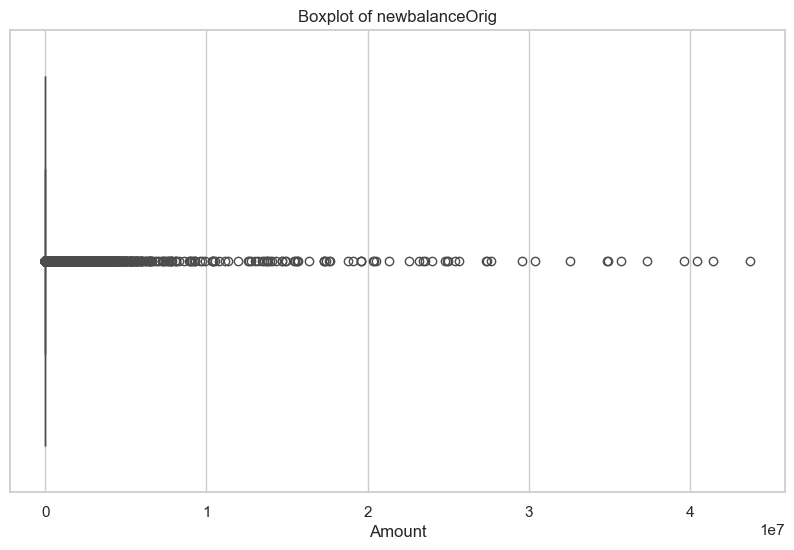

In [24]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='newbalanceOrig', data=df)
plt.title('Boxplot of newbalanceOrig')
plt.xlabel('Amount')
plt.show()

No outliers are found.

4) Next, moving on to 'oldbalanceDest'

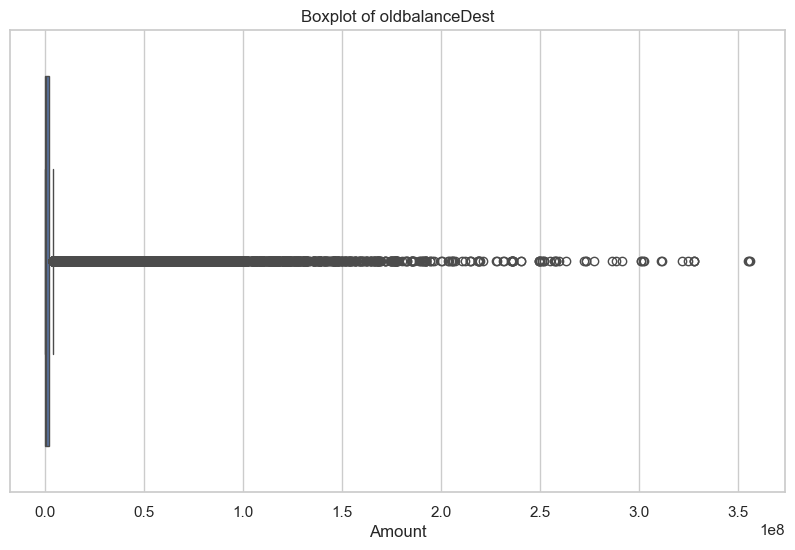

In [25]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='oldbalanceDest', data=df)
plt.title('Boxplot of oldbalanceDest')
plt.xlabel('Amount')
plt.show()

Clearly, outliers are present.

In [26]:
# Identify outliers
outliers = df[df['oldbalanceDest'] > 350000000]

# Display the outliers
print("Outliers in oldbalanceDest:")
print(outliers[['amount', 'nameOrig', 'nameDest']])

Outliers in oldbalanceDest:
            amount     nameOrig    nameDest
5380607  194946.47     C4896808  C439737079
5486389  635405.82  C1666289749  C439737079
5920180  163389.56  C1323053481  C439737079


In [27]:
# Remove outliers from the DataFrame
df = df[df['oldbalanceDest'] < 350000000]

# Display the shape of the DataFrame after removing outliers
print("DataFrame Shape after Removing Outliers:", df.shape)

DataFrame Shape after Removing Outliers: (2770403, 10)


4) Lastly, we move to 'newbalanceDest'

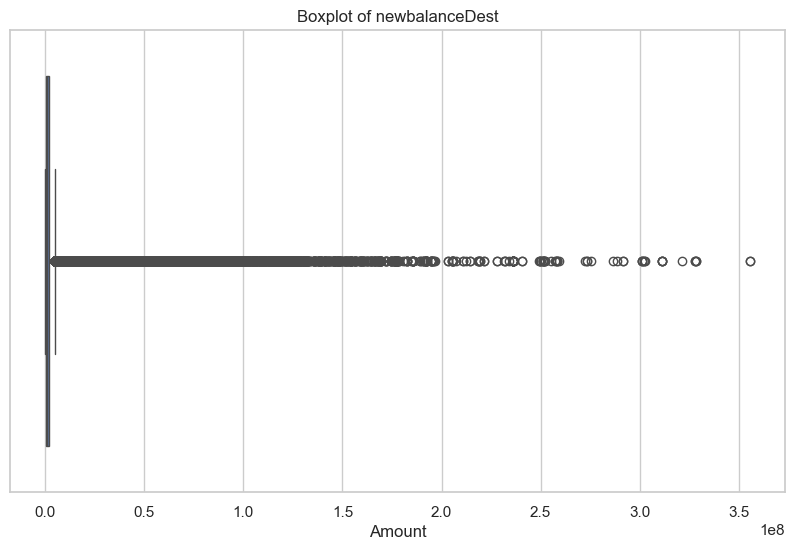

In [28]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='newbalanceDest', data=df)
plt.title('Boxplot of newbalanceDest')
plt.xlabel('Amount')
plt.show()

Here also, outliers are present.

In [29]:
# Identify outliers
outliers = df[df['newbalanceDest'] > 350000000]

# Display the outliers
print("Outliers in newbalanceDest:")
print(outliers[['amount', 'nameOrig', 'nameDest']])

Outliers in newbalanceDest:
              amount     nameOrig    nameDest
4124250   3325263.90  C1812458696  C439737079
4133583  30638354.89  C1800693711  C439737079


In [30]:
# Remove outliers from the DataFrame
df = df[df['newbalanceDest'] < 350000000]

# Display the shape of the DataFrame after removing outliers
print("DataFrame Shape after Removing Outliers:", df.shape)

DataFrame Shape after Removing Outliers: (2770401, 10)


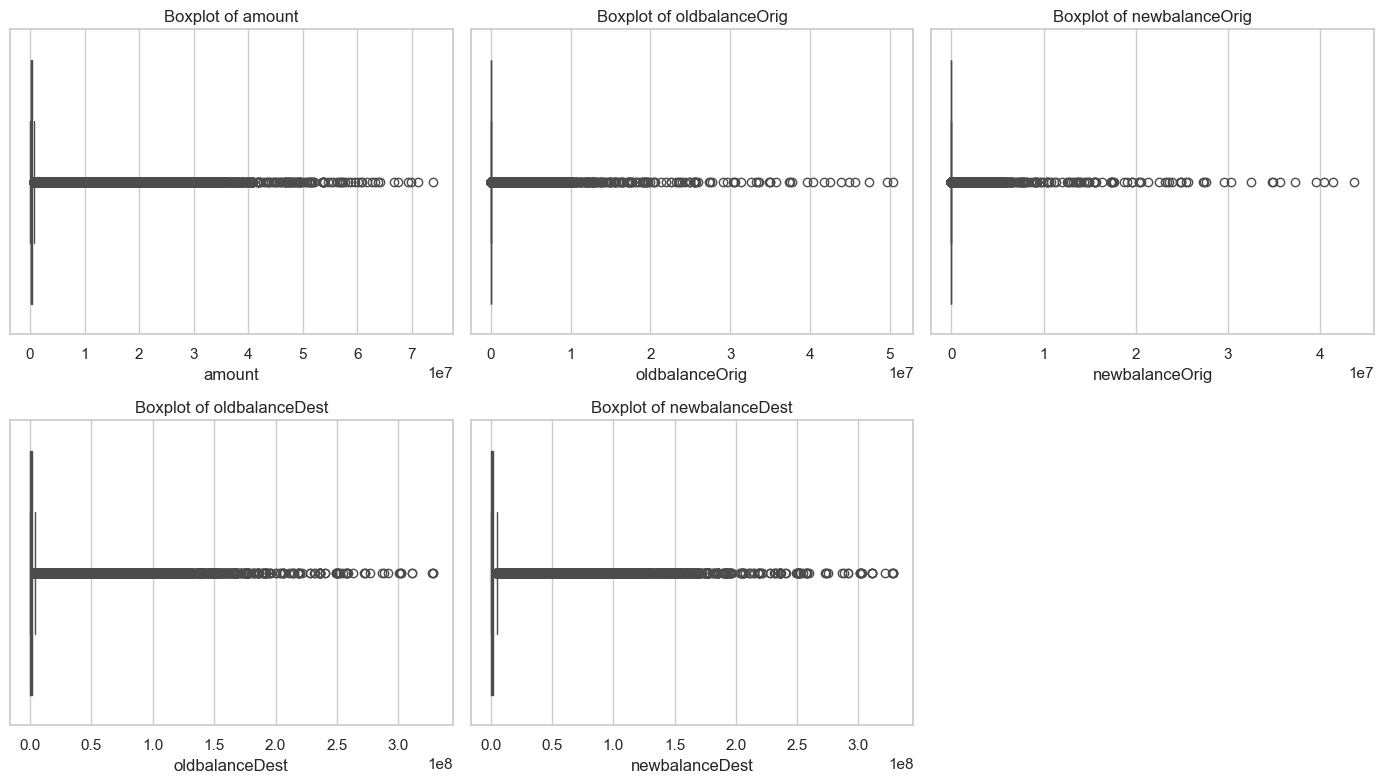

In [31]:
# Define the columns to create boxplots for
columns_to_boxplot = ['amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Set the style for the plots
sns.set(style="whitegrid")

# Create boxplots for each specified column
plt.figure(figsize=(14, 8))
for i, column in enumerate(columns_to_boxplot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

All the outliers have been removed, and the plots now appear better.

#### Exploring the new Data Frame

In [32]:
df

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1


In [33]:
isFraud_count = df['isFraud'].value_counts()

# Display the count
print("(isFraud=1):", isFraud_count[1])
print("(isFraud=0):", isFraud_count[0])

(isFraud=1): 8211
(isFraud=0): 2762190


#### Checking if there are rows where 'nameOrig' == 'nameDest' i.e. checking for error transactions

In [34]:
# Check for rows where 'nameOrig' is equal to 'nameDest'
same_name_orig_dest = df[df['nameOrig'] == df['nameDest']]

# Display the rows where 'nameOrig' is equal to 'nameDest'
print("Rows where nameOrig is equal to nameDest:")
print(same_name_orig_dest)

Rows where nameOrig is equal to nameDest:
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrig, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud]
Index: []


There are no error transactions

#### Counting number of unique 'nameOrig' in case of Fraud Transactions

In [35]:
# Filter the DataFrame for fraud transactions
fraud_transactions = df[df['isFraud'] == 1]

# Count the distinct 'nameOrig' values for fraud transactions
distinct_name_orig_count = fraud_transactions['nameOrig'].nunique()

# Display the count
print("Distinct 'nameOrig' count for fraud transactions:", distinct_name_orig_count)

Distinct 'nameOrig' count for fraud transactions: 8211


The number of unique 'nameOrig' is the same as the number of fraud transactions. This implies that every time a new client is scammed, so this column is of no use. (Which makes sense that the client may get aware and take care in future.)

#### Counting number of unique 'nameDest' in case of Fraud Transactions

In [36]:
# Count the distinct 'nameOrig' values for fraud transactions
distinct_name_Dest_count = fraud_transactions['nameDest'].nunique()

# Display the count
print("Distinct 'nameOrig' count for fraud transactions:", distinct_name_Dest_count)

Distinct 'nameOrig' count for fraud transactions: 8167


The number of unique 'nameDest' is not the same as the number of fraud transactions; it is lesser than that. This implies that it is useful (these are the details of the scammers, so it is anyhow useful in model building).

In [37]:
# Drop the 'nameOrig' column from the DataFrame
df.drop('nameOrig', axis=1, inplace=True)

In [38]:
df

,step,type,amount,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.00,0.0,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.0,C38997010,21182.00,0.00,1
15,1,CASH_OUT,229133.94,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.0,C2080388513,0.00,0.00,1


#### Further exploring the importance of other features

In [39]:
fraud_transactions_with_zero_balance = df[(df['isFraud'] == 1) & (df['newbalanceDest'] == 0)]
number_of_fraud_transactions_with_zero_balance = len(fraud_transactions_with_zero_balance)

print("Number of fraud transactions with new destination balance = 0:", number_of_fraud_transactions_with_zero_balance)

Number of fraud transactions with new destination balance = 0: 4089


This indicates that a significant number of fraud transactions exhibit a new destination balance (newbalanceDest) equal to zero, accounting for nearly half of all fraud transactions. Consequently, there appears to be a discernible pattern, underscoring the importance of this feature for the model.

In [40]:
fraud_transactions_with_zero_balance = df[(df['isFraud'] == 1) & (df['oldbalanceDest'] == 0)]
number_of_fraud_transactions_with_zero_balance = len(fraud_transactions_with_zero_balance)

print("Number of fraud transactions with old destination balance = 0:", number_of_fraud_transactions_with_zero_balance)

Number of fraud transactions with old destination balance = 0: 5349


Additionally, it is evident that the old destination balance (oldbalanceDest) also plays an important role in these transactions.

In [41]:
fraud_transactions_with_zero_balance = df[(df['isFraud'] == 1) & (df['newbalanceOrig'] == 0)]
number_of_fraud_transactions_with_zero_balance = len(fraud_transactions_with_zero_balance)

print("Number of fraud transactions with newbalanceOrig = 0:", number_of_fraud_transactions_with_zero_balance)

Number of fraud transactions with newbalanceOrig = 0: 8053


This indicates that in the majority of fraud transactions, the entire amount was siphoned from the client. Therefore, the new balance origin (newbalanceOrig) is also a crucial feature. Additionally, it becomes evident that in the majority of these cases, the amount equals the old balance origin (oldbalanceOrig). Consequently, all these features are deemed important for understanding the underlying patterns in such transactions.

The number of non-fraud transactions is still significantly larger than fraud transactions; therefore, we need to perform random sampling.

### Random Over Sampling

In [42]:
# Use RandomUnderSampler to balance the class distribution
oversampler = RandomOverSampler(sampling_strategy=1, random_state=42)
df_resampled, _ = oversampler.fit_resample(df, df['isFraud'])

# Display the count of each class in the resampled data
isFraud_count_resampled = df_resampled['isFraud'].value_counts()
print("(isFraud=1) in Resampled Data:", isFraud_count_resampled[1])
print("(isFraud=0) in Resampled Data:", isFraud_count_resampled[0])

(isFraud=1) in Resampled Data: 2762190
(isFraud=0) in Resampled Data: 2762190


In [43]:
df = df_resampled

### One hot encoding

In [44]:
# Perform one-hot encoding on the 'type' column
df = pd.get_dummies(df, columns=['type'])

### Train Test Split

In [45]:
# Define features (X) and target variable (y)
X = df.drop(['isFraud', 'nameDest'], axis=1)  # Features (excluding the target column)
y = df['isFraud']  # Target variable

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape - Features:", X_train.shape, "Target:", y_train.shape)
print("Testing set shape - Features:", X_test.shape, "Target:", y_test.shape)

Training set shape - Features: (4419504, 8) Target: (4419504,)
Testing set shape - Features: (1104876, 8) Target: (1104876,)


### Model Building

**The logic behind the model is as follows:**

Initially, we had data encompassing various types of transactions. However, for the sake of data reduction, we retained only two types and removed the rest. It's essential to note that future, unseen data might include all transaction types. Additionally, during the data split, we excluded the nameDest column due to the challenge of encoding numerous unique IDs. Despite this, the nameDest column is deemed crucial.

The model operates as follows:

The model first checks the nameDest. If it matches the previous record of fraudulent nameDest, it labels the transaction as fraud. This step is crucial as we have records of IDs, and the use of different transaction types in the future could be anticipated.

Subsequently, the model examines the transaction type. If it is a type other than "transfer" or "cashout," based on the provided data, we label it as non-fraudulent. For transactions belonging to these specific types, we pass the data point through the machine learning model for classification.

**Advantage -** This approach reduces computational complexity since we don't need to train the model on the entire dataset. Additionally, it provides flexibility to modify the model in the future if needed.

**Base machine learning model (Logistic Regression)** - We selected logistic regression as our base model because it is simple, interpretable, and efficient for binary classification. Additionally, we utilized BayesSearchCV to find the best parameters and enhance the model accuracy.

In [46]:
# Ignore the specific warning related to the objective being evaluated at the same point
warnings.filterwarnings("ignore", category=UserWarning, module="skopt.optimizer.optimizer")

# model
logreg = LogisticRegression(random_state=42)
logreg_param_dist = {'C': (1e-6, 1e+6, 'log-uniform')}
logreg_search = BayesSearchCV(logreg, logreg_param_dist, n_iter=50, random_state=42, cv=5, n_jobs=-1)
logreg_search.fit(X_train, y_train)
logreg_best_params = logreg_search.best_params_

# Print best parameters
print("Logistic Regression Best Parameters:", logreg_best_params)

# Evaluate model on the test set
logreg_accuracy = logreg_search.score(X_test, y_test)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Classification Report
logreg_best_model = logreg_search.best_estimator_
logreg_pred = logreg_best_model.predict(X_test)
logreg_classification_report = classification_report(y_test, logreg_pred)
print("Logistic Regression Classification Report:\n", logreg_classification_report)


Logistic Regression Best Parameters: OrderedDict([('C', 1.10551257524209e-06)])
Logistic Regression Accuracy: 0.9225614458093034
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92    551878
           1       0.89      0.97      0.93    552998

    accuracy                           0.92   1104876
   macro avg       0.93      0.92      0.92   1104876
weighted avg       0.93      0.92      0.92   1104876



As evident from the model scores, our model is trained very well, achieving a very high accuracy.

#### Custom model

In [47]:
def custom_model_predict(transaction_record, fraud_nameDest_records, machine_learning_model):
    # Check if nameDest matches any previous fraud nameDest
    if transaction_record['nameDest'] in fraud_nameDest_records:
        return 1  # Label as fraud
    else:
        # Check transaction type
        if transaction_record['type'] not in ['TRANSFER', 'CASH_OUT']:
            return 0  # Label as not fraud
        else:
            #encoding
            if transaction_record['type'] == 'TRANSFER':
                type_TRANSFER = True
                type_CASH_OUT = False
            else:
                type_TRANSFER = False
                type_CASH_OUT = True
            
            # Prepare the feature vector for prediction as a DataFrame
            features_df = pd.DataFrame({
                'step': [transaction_record['step']],
                'amount': [transaction_record['amount']],
                'oldbalanceOrig': [transaction_record['oldbalanceOrig']],
                'newbalanceOrig': [transaction_record['newbalanceOrig']],
                'oldbalanceDest': [transaction_record['oldbalanceDest']],
                'newbalanceDest': [transaction_record['newbalanceDest']],
                'type_CASH_OUT': [type_CASH_OUT],
                'type_TRANSFER': [type_TRANSFER],
            })
            # Pass through the machine learning model for classification
            prediction = machine_learning_model.predict(features_df)

            return prediction[0]# Return the predicted label

# Assuming feature_order is a list containing the column names in the same order as used during training
feature_order = ['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_TRANSFER', 'type_CASH_OUT']
fraud_nameDest_records = set(fraud_transactions['nameDest'])  
machine_learning_model = logreg_best_model

#### Example Usage

1) We provide with a 'nameDest' corresponding to one of the fraudulent transactions, and we set the transaction type to 'PAYMENT'.

In [48]:
new_transaction_record = {'step': 4, 'type':'PAYMENT', 'amount':10000, 'nameOrig':'C1666544295', 'oldbalanceOrig':12000, 'newbalanceOrig':110000, 'nameDest':'C38997010', 'oldbalanceDest':0, 'newbalanceDest':0, 'isFlaggedFraud':0}
prediction = custom_model_predict(new_transaction_record, fraud_nameDest_records, machine_learning_model)
print("Custom Model Prediction:", prediction)

Custom Model Prediction: 1


Our model made a correct prediction as the 'nameDest' was present in the list of fraud transactions.

2) We now provide a new 'nameDest' along with the transaction type 'DEBIT'.

In [49]:
new_transaction_record = {'step': 52, 'type':'DEBIT', 'amount':20000, 'nameOrig':'C1666544963', 'oldbalanceOrig':2000, 'newbalanceOrig':0, 'nameDest':'C38997314', 'oldbalanceDest':0, 'newbalanceDest':0, 'isFlaggedFraud':0}
prediction = custom_model_predict(new_transaction_record, fraud_nameDest_records, machine_learning_model)
print("Custom Model Prediction:", prediction)

Custom Model Prediction: 0


Our model once again made a correct prediction, this time due to the transaction type being 'DEBIT'.

3) This time, we use 'CASH_OUT' and 'TRANSFER' transaction types.

In [50]:
new_transaction_record = {'step': 52, 'type':'TRANSFER', 'amount':20000, 'nameOrig':'C1666544963', 'oldbalanceOrig':20000, 'newbalanceOrig':0, 'nameDest':'C38997314', 'oldbalanceDest':0, 'newbalanceDest':0, 'isFlaggedFraud':0}
prediction = custom_model_predict(new_transaction_record, fraud_nameDest_records, machine_learning_model)
print("Custom Model Prediction:", prediction)

Custom Model Prediction: 1


In [51]:
new_transaction_record = {'step': 385, 'type':'CASH_OUT', 'amount':800, 'nameOrig':'C1666544963', 'oldbalanceOrig':3500, 'newbalanceOrig':2700, 'nameDest':'C38997314', 'oldbalanceDest':5240, 'newbalanceDest':0, 'isFlaggedFraud':0}
prediction = custom_model_predict(new_transaction_record, fraud_nameDest_records, machine_learning_model)
print("Custom Model Prediction:", prediction)

Custom Model Prediction: 1


### Further Exploring and Suggestions

In [52]:
# Count total number of fraud transactions
total_fraud_transactions = data[data['isFraud'] == 1].shape[0]

# Count fraud transactions where newbalanceOrig is 0
fraud_transactions_with_zero_balance = data[(data['isFraud'] == 1) & (data['newbalanceOrig'] == 0)].shape[0]

# Print the results
print(f'Total number of fraud transactions: {total_fraud_transactions}')
print(f'Number of fraud transactions with newbalanceOrig = 0: {fraud_transactions_with_zero_balance}')

Total number of fraud transactions: 8213
Number of fraud transactions with newbalanceOrig = 0: 8053


Therefore, in the majority of fraud transactions, the new balanceOrig is 0, indicating that the entire amount was withdrawn from the bank. As a result, the bank should double-check such transactions and consider implementing additional security steps for emptying an account.

In [53]:
# Filter fraud transactions of type 'TRANSFER'
fraud_transfer = data[(data['isFraud'] == 1) & (data['type'] == 'TRANSFER')]

# Filter fraud transactions of type 'TRANSFER' with oldbalanceOrig = 0 and newbalanceOrig = 0
fraud_transfer_zero_balance = data[(data['isFraud'] == 1) & (data['type'] == 'TRANSFER') & (data['oldbalanceDest'] == 0) & (data['newbalanceDest'] == 0)]

# Get the counts
total_fraud_transfer_count = len(fraud_transfer)
fraud_transfer_zero_balance_count = len(fraud_transfer_zero_balance)

# Print the comparison
print(f"Total fraud transactions of type 'TRANSFER': {total_fraud_transfer_count}")
print(f"Fraud transactions of type 'TRANSFER' with oldbalanceDest = 0 and newbalanceDest = 0: {fraud_transfer_zero_balance_count}")

Total fraud transactions of type 'TRANSFER': 4097
Fraud transactions of type 'TRANSFER' with oldbalanceDest = 0 and newbalanceDest = 0: 4068


Therefore, in the majority of fraud transactions of type 'TRANSFER,' both oldbalancedest and newbalancedest are equal to 0. This implies that information for the destination account is not available. Consequently, the bank should take appropriate measures, such as not allowing transfers when destination balance details are unavailable

## Thank you

**-- Gautam Singh**